# 使用支持向量机进行分类

多变量模式分析（MVPA）在人类电生理研究中越来越受欢迎（Cichy等人，2014；Stokes等人，2015；）。这种方法允许识别与电生理活动的分布式模式相关的代表性特定信息。在这个例子中，我们演示了如何应用支持向量机（SVM）对两类试验进行分类。

## Preparation
Import the relevant modules:

In [1]:
import os.path as op
import os
import sys
import matplotlib.pyplot as plt
import numpy as np
import mne
from mne_bids import BIDSPath
from mne.decoding import (SlidingEstimator, GeneralizingEstimator, Scaler,
                          cross_val_multiscore, LinearModel, get_coef,
                          Vectorizer, CSP)

import sklearn.svm
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression

分类基于Scikit-Learning（`sklearn`）包中的工具。

Set the local paths of the data:

In [2]:
subject = '01'
session = '01'
task = 'SpAtt'  # name of the task
run = '02'  # we have two runs for this subject, let's look at run = 2
meg_suffix = 'meg'
epo_suffix = 'epo'

deriv_root = r'/home/ubuntu/database/ds004346-FLUX/derivatives/analysis'
bids_path = BIDSPath(subject=subject, session=session,
            task=task, run=run, suffix=epo_suffix, datatype='meg',
            root=deriv_root, extension='.fif', check=False)
print(bids_path.basename,bids_path.fpath)

sub-01_ses-01_task-SpAtt_run-02_epo.fif /home/ubuntu/database/ds004346-FLUX/derivatives/analysis/sub-01/ses-01/meg/sub-01_ses-01_task-SpAtt_run-02_epo.fif


## 读取和准备基于试次的数据
读取分段：

In [3]:
epochs = mne.read_epochs(bids_path.fpath,
                         preload=True,
                         verbose=True).pick(['meg'])

Reading /home/ubuntu/database/ds004346-FLUX/derivatives/analysis/sub-01/ses-01/meg/sub-01_ses-01_task-SpAtt_run-02_epo.fif ...
    Found the data of interest:
        t =   -2500.00 ...    2000.00 ms
        0 CTF compensation matrices available
Not setting metadata
136 matching events found
No baseline correction applied
0 projection items activated


现在过滤数据。在这种情况下，我们以10 Hz低通数据。这是在将试验切割成更短的片段之前完成的，以减少过滤的边缘效应。过滤器还用于执行数据的时间平滑，这将有利于分类。 

In [4]:
epochs_rs = epochs.copy().filter(0,10)

Setting up low-pass filter at 10 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal lowpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Upper passband edge: 10.00 Hz
- Upper transition bandwidth: 2.50 Hz (-6 dB cutoff frequency: 11.25 Hz)
- Filter length: 1321 samples (1.321 s)



[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  71 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done 161 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done 287 tasks      | elapsed:    0.1s
[Parallel(n_jobs=1)]: Done 449 tasks      | elapsed:    0.1s
[Parallel(n_jobs=1)]: Done 647 tasks      | elapsed:    0.1s
[Parallel(n_jobs=1)]: Done 881 tasks      | elapsed:    0.2s
[Parallel(n_jobs=1)]: Done 1151 tasks      | elapsed:    0.2s
[Parallel(n_jobs=1)]: Done 1457 tasks      | elapsed:    0.3s
[Parallel(n_jobs=1)]: Done 1799 tasks      | elapsed:    0.4s
[Parallel(n_jobs=1)]: Done 2177 tasks      | elapsed:    0.4s
[Parallel(n_jobs=1)]: Done 2591 tasks      | elapsed:    0.5s
[Parallel(n_jobs=1)]: Done 3041 tasks      | elapsed:    0.6s
[Parallel(n_jobs=1)]: Done 3527 tasks      | elapsed:    0.7s
[Parallel(n_jobs=1)]: Done 4049 tasks      | elapsed:    0.8s
[Parallel(n_jobs=1)]: Done 4607 tasks      | elapsed:    0.9s
[Parallel(n_job

将数据下采样至100 Hz以减少计算时间。然后将感兴趣的时间窗口设置为目标激发前后的-0.1到0.5秒。 

In [5]:
epochs_rs.resample(100)
epochs_rs.crop(tmin=-0.1, tmax=0.5)

<EpochsFIF | 136 events (all good), -0.1 – 0.5 s (baseline off), ~19.9 MiB, data loaded,
 'cue_left': 63
 'cue_right': 73>

## 设置分类器
SVM在*scikit-learn*包中实现，必须应用相应的应用程序编程接口（API）。
矩阵$X$（特征）是一个三维矩阵（试次x导联x时间点）：


In [6]:
X = epochs_rs.get_data(picks='meg') 
X.shape

(136, 306, 61)

在这种情况下，我们有256次试次和61个时间点。 

向量$y$（也是termet目标）包含256个值，表示关注左或右试验。试次代码（分别为4和5）需要转换为值1和2：

In [7]:
epochs.events

array([[1684478,       0,       4],
       [1691642,       0,       4],
       [1698890,       0,       5],
       [1705721,       0,       5],
       [1712810,       0,       5],
       [1728849,       0,       5],
       [1736197,       0,       4],
       [1745137,       0,       4],
       [1761401,       0,       5],
       [1769900,       0,       5],
       [1776881,       0,       5],
       [1783687,       0,       5],
       [1808449,       0,       5],
       [1817549,       0,       5],
       [1824655,       0,       4],
       [1833420,       0,       4],
       [1840568,       0,       4],
       [1847682,       0,       4],
       [1865564,       0,       5],
       [1872687,       0,       4],
       [1879751,       0,       5],
       [1887583,       0,       4],
       [1904689,       0,       5],
       [1913463,       0,       4],
       [1920577,       0,       5],
       [1929226,       0,       4],
       [1938242,       0,       5],
       [1946132,       0,   

In [8]:
temp = epochs.events[:, 2]
temp[epochs.events[:,2] == 4] = 1
temp[epochs.events[:,2] == 5] = 2
y = temp
print(y)

[1 1 2 2 2 2 1 1 2 2 2 2 2 2 1 1 1 1 2 1 2 1 2 1 2 1 2 2 1 2 2 2 1 2 2 2 1
 2 2 1 2 1 2 2 2 1 1 2 1 2 2 1 2 1 1 2 2 1 2 1 1 1 2 1 1 1 1 1 2 1 2 2 2 2
 1 1 2 1 2 2 1 2 1 2 1 2 2 1 2 2 1 2 2 1 1 2 1 2 1 2 1 2 2 2 1 2 2 1 1 2 1
 1 1 1 2 2 2 2 1 1 1 2 1 2 1 2 2 1 2 2 1 1 2 2 1 1]


函数*make_pipeline* 来自*scikit-learn*。它定义了与估计器一起使用的变换。*Vectorizer()* 将X转换为2D数组（按特征采样）。

*Standard ardScaler()* 通过去除平均值并缩放为单位方差来标准化数据。

In [9]:
clf = make_pipeline(Vectorizer(),StandardScaler(),  
                   LinearModel(sklearn.svm.SVC(kernel = 'linear')))                          

最后必须定义估计器。我们在这里应用 *SlidingEstimator*，它使用特征 $X$ 和目标 $y$ 作为输入，并使用 *clf* 定义管道。目的是区分实验条件随时间的变化，即，在哪些时间点我们可以区分左注意力和右注意力？

In [10]:
time_decod = SlidingEstimator(clf, n_jobs=-1, scoring='roc_auc', verbose=True)

## 执行分类
分类将使用SVM逐时间点执行，方法是在5次运行中对80%的试验进行20%的测试训练。这导致5折交叉验证（*cv=5*）。输出将报告为曲线下的区域（AUC）。 

In [11]:
scores = cross_val_multiscore(time_decod, X, y, cv=5, n_jobs=-1)

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 256 concurrent workers.



  0%|          | Fitting SlidingEstimator : 0/61 [00:00<?,       ?it/s]

  0%|          | Fitting SlidingEstimator : 0/61 [00:00<?,       ?it/s]


  0%|          | Fitting SlidingEstimator : 0/61 [00:00<?,       ?it/s]



  0%|          | Fitting SlidingEstimator : 0/61 [00:00<?,       ?it/s]
  5%|▍         | Fitting SlidingEstimator : 3/61 [00:00<00:05,   11.45it/s]


 46%|████▌     | Fitting SlidingEstimator : 28/61 [00:00<00:00,  107.66it/s]



 33%|███▎      | Fitting SlidingEstimator : 20/61 [00:00<00:00,   81.83it/s]

 41%|████      | Fitting SlidingEstimator : 25/61 [00:00<00:00,   97.09it/s]
 90%|█████████ | Fitting SlidingEstimator : 55/61 [00:00<00:00,  190.17it/s]


 74%|███████▍  | Fitting SlidingEstimator : 45/61 [00:00<00:00,  153.85it/s]

100%|██████████| Fitting SlidingEstimator : 61/61 [00:00<00:00,  192.34it/s]



100%|██████████| Fitting SlidingEstimator : 61/61 [00:00<00:00,  190.49it/s]
 67%|██████▋   | Fitting SlidingEstimator : 41/61 [00:00<00:00,  142.05it/s]
1

## 绘制结果
为了绘制结果，平均分数并绘制：

In [12]:
scores = np.mean(scores, axis=0)

Text(0.5, 1.0, 'Sensor space decoding')

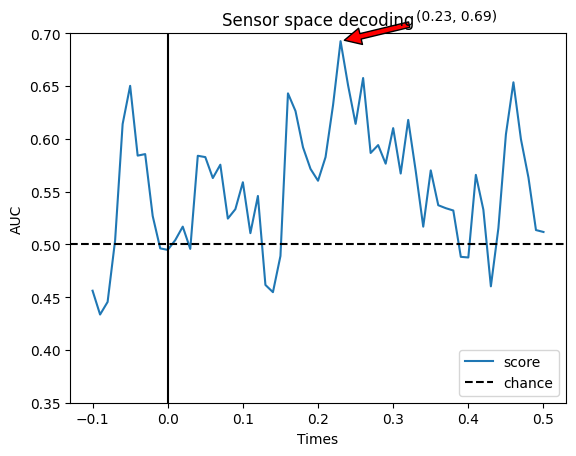

In [16]:
fig, ax = plt.subplots()
plt.ylim([0.35, 0.7])
ax.plot(epochs_rs.times, scores, label='score')
ax.axhline(.5, color='k', linestyle='--', label='chance')

# 找到最高点的坐标
max_index = scores.argmax()
max_x = epochs_rs.times[max_index]
max_y = scores[max_index]

# 标注最高点的坐标
ax.annotate(f'({max_x:.2f}, {max_y:.2f})', 
            xy=(max_x, max_y), 
            xytext=(max_x + 0.1, max_y + 0.02), 
            arrowprops=dict(facecolor='red', shrink=0.05))

ax.set_xlabel('Times')
ax.set_ylabel('AUC')  # Area Under the Curve
ax.legend()
ax.axvline(.0, color='k', linestyle='-')
ax.set_title('Sensor space decoding')

图中显示了分类精度（AUC）随时间的变化。最佳分类在目标出现后~230毫秒获得，为~0.69。 


## Preregistration and publications

Publication, example:

"A multi-variate pattern analysis was applied to the MEG data to classify whether the participants attended left or right. The data were lowpass filtered at 10 Hz and then downsampled to 100 Hz. The time-points in the interval -0.1 to 0.5 s around the target onset was considered. The data were standardized by removing the mean and scaling to unit variance per sensor. A support vector machine (Cortes abd Vapnik, 1995) from Scikit-learn (https://scikit-learn.org/) was applied to classify the data as a function of time. A 5-fold cross-validation procedure was used and the classificaiton rate was reported as Area Under the Curve"

## References 

* Cichy RM, Pantazis D, Oliva A.(2014) Resolving human object recognition in space and time. Nat Neurosci. 17(3):455-62. doi: 10.1038/nn.3635
* Cortes, C, Vapnik, V (1995) Support-vector networks. Mach Learn 20, 273–297 
* Stokes MG, Wolff MJ, Spaak E. (2015) Decoding Rich Spatial Information with High Temporal Resolution. Trends Cogn Sci. 19(11):636-638. doi: 10.1016/j.tics.2015.08.016

